# Evaluation trained discrete model of a Lagrangian density

## Loading and initialisation of the trained model

In [54]:
# load packages, training modules, setup model
include("LinearMOR.jl")

# load data of trained model
ROMrun_data=JSON.parsefile("54750_2023-05-29_16-41-33run_WaveROM_param_data.json");
include("loss_info_training.jl"); # provides records of losses during training

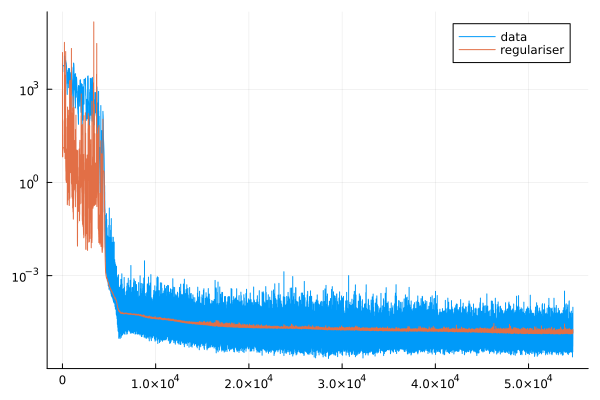

In [67]:
plot(transpose([1. 0; 0 1e-8]*loss_info),yscale=:log10,label=["data" "regulariser"])

In [68]:
no_epochs = size(loss_info,2) - size(loss_info,2) % 10 # last saved epoch
print("final loss data/regulariser: "*string([1. 0; 0 1e-8]*loss_info[:,no_epochs])*"\n")
print("number of epochs: "*string(no_epochs))

final loss data/regulariser: [1.1895712876905488e-5, 1.5316947109274705e-5]
number of epochs: 54750

# Evaluation

In [116]:
# Solver for discrete Euler--Lagrange equations
function SolveDEL(Ld,q0,q1)
    q2 = 2*q1-q0
    objective(q2) = odeDEL(Ld,q0,q1,q2)
    return nlsolve(objective,q2,autodiff = :forward)
end

function SolveDEL(Ld,q0,q1,N)
    q = zeros((MOR_dim,N+1))
    q[:,1]=q0
    q[:,2]=q1
    for k=2:N
        q[:,k+1] = SolveDEL(Ld,q[:,k-1],q[:,k]).zero
    end
    return q
end

SolveDEL (generic function with 2 methods)

In [117]:
include("plotting_tools.jl")
plotU, contourU, plotAllU = InstantiatePlotFun(dt,dx)

(plotU, contourU, plotAllU)

In [118]:
# value of losses after training
paramsVecROM_trained = vcat(ROMrun_data["learned_parameters"]...);
lossesROM(paramsVecROM_trained,train_loaderROM.data)

2-element Vector{Float64}:
    1.1895712876905468e-5
 1531.6947109274709

In [119]:
function LdTrained(q0,q1)
    x0 = [q0;q1]
    return LdArchitectureROM(paramsVecROM_trained,x0)
end

LdTrained (generic function with 1 method)

## How well can we recover training data?

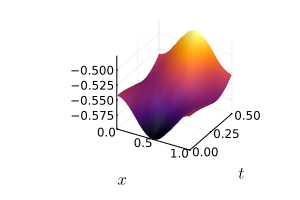

In [120]:
# recover training data
sample_no = 8
u0=training_data[sample_no][1,:]
u1=training_data[sample_no][2,:]
plotU(training_data[sample_no])

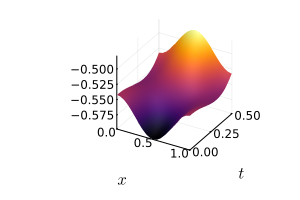

In [121]:
q0 = MOR_basis'*u0
q1 = MOR_basis'*u1
q_recover_data=SolveDEL(LdTrained,q0,q1,N)
U_recover_data = (MOR_basis*q_recover_data)';
plotU(U_recover_data)

In [122]:
maximum(abs.(U_recover_data - training_data[sample_no]))

0.0026990045650788774

## Continue a solution

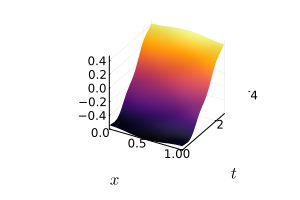

In [123]:
q0 = MOR_basis'*u0
q1 = MOR_basis'*u1
q_continue=SolveDEL(LdTrained,q0,q1,N*5)
U_continue = (MOR_basis*q_continue)';
plotU(U_continue)

## unseen initial values

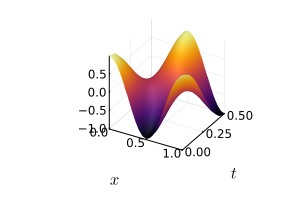

In [165]:
q0 = MOR_basis'*cos.(2*pi/l*XMesh)
q1 = MOR_basis'*cos.(2*pi/l*XMesh)
q_unseen=SolveDEL(LdTrained,q0,q1,N)
U_unseen = (MOR_basis*q_unseen)';
plotU(U_unseen)
#savefig("ROM_unseen_success.png")

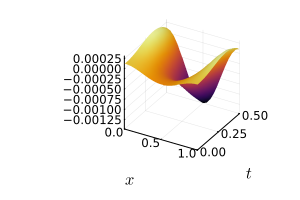

In [163]:
q0 = MOR_basis'*sin.(4*pi/l*XMesh)
q1 = MOR_basis'*sin.(4*pi/l*XMesh)
q_unseen=SolveDEL(LdTrained,q0,q1,N)
U_unseen = (MOR_basis*q_unseen)';
plotU(U_unseen)
#savefig("ROM_unseen_fail.png")

## travelling wave

In [145]:
# reference: tw of lattice

wave_no = 1
kappa = 2*pi*wave_no/l

lattice_eq_rhs = 1+ dt^2/dx^2*(cos(kappa*dx)-1) - dt^2/2

if abs(lattice_eq_rhs)>1
    print("The discretised PDE does not admit real valued travelling wave with this wave number for this potential/dx/dt. Discriminant ")
    print(lattice_eq_rhs)
end

c_tw_discrete=acos(lattice_eq_rhs)/(kappa*dt)

amplitude_discrete = [1.,0.]
tw_discrete(t,x) = amplitude_discrete[1]*sin(kappa*(x-c_tw_discrete*t))+amplitude_discrete[2]*cos(kappa*(x-c_tw_discrete*t))
U_tw_discrete = tw_discrete.(TMesh,transpose(XMesh));

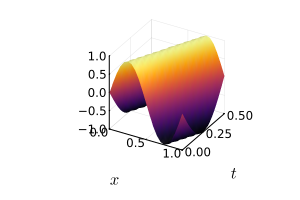

In [146]:
plotU(U_tw_discrete)

In [147]:
# compression to variables on latent space
q_tw_discrete = MOR_basis'*U_tw_discrete'

# reconstruction error for reference TW
U_tw_reconstructed = (MOR_basis*q_tw_discrete)'
maximum(abs.(U_tw_reconstructed - U_tw_discrete ))

1.0000232954887913

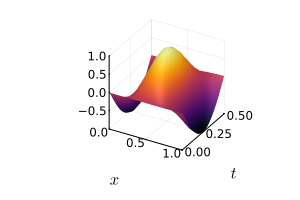

In [161]:
plotU(U_tw_reconstructed)
#savefig("TW1_ROM_projected_reconstructed.png")

In [149]:
# consistency of projected TW with learned LdODE
triples_tw = [q_tw_discrete[:,j:j+2] for j=1:size(q_tw_discrete,2)-2]; # data triples
consistency_tw_ROM = (triple->odeDELTestROM(paramsVecROM_trained,triple)).(triples_tw)
consistency_tw_ROM = hcat(consistency_tw_ROM...)
maximum(sqrt.(sum(consistency_tw_ROM.^2,dims=1)))

0.009014207037621916

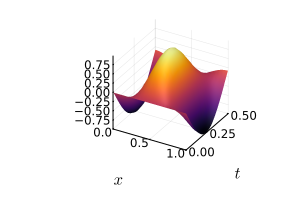

In [159]:
q_tw_computed = SolveDEL(LdTrained,q_tw_discrete[:,1],q_tw_discrete[:,2],N)
U_tw_computed_reconstructed = (MOR_basis*q_tw_computed)'
plotU(U_tw_computed_reconstructed)
#savefig("TW1_ROM_initialised_from_exactTW1.png")

### Can we find the travelling wave from an ansatz?

In [26]:
include("FindTravellingWave.jl")
include("SpectralTools.jl")

SpectralInterpolation (generic function with 1 method)

In [27]:
# set-up of optimisation problem
f_to_frhatR, frhatR_to_f = translate_fourier_coefficients(M)                                   # helper function
cfrhatR0 = [c_tw_discrete;f_to_frhatR(U_tw_discrete[1,:])];                                    # initial guess from reference
cfrhatR = cfrhatR0 + 0.5*randn(MersenneTwister(1234),Float64,length(f_to_frhatR(zeros(M)))+1)  # perturbed initial guess
loss_hist_d_tw = zeros(2,0);                                                                   # init. loss variable

train_discrete_tw! = find_discrete_travelling_waveROM(LdTrained,MOR_basis,cfrhatR,N,dt,dx);

In [28]:
# Run optimisation scheme. Updates variable cfrhatR and loss_hist_d_tw

train_discrete_tw!(10000; print_every=500, save_every=Inf)

[1.440842942142251e-6, 6.365413301692246e-25]
[4.825667291034531e-7, 2.3126179889424567e-24]
[3.0996559489542883e-7, 2.076587017825534e-23]
[2.0663006578949592e-7, 1.450106391014519e-22]
[1.4139987897863724e-7, 8.093458836844547e-22]
[9.863666867909012e-8, 3.7765851101051896e-21]
[6.983035704617952e-8, 1.5259074560104204e-20]
[5.0049193767861445e-8, 5.481961540892231e-20]
[3.628136265060328e-8, 1.7867694942223737e-19]
[2.6607809993438858e-8, 5.365809901760254e-19]
[1.9763857616690276e-8, 1.5024607862048706e-18]
[1.4894278693830432e-8, 3.958355465315432e-18]
[1.1409964666094895e-8, 9.878686276785155e-18]
[8.900383196985218e-9, 2.3465533669652975e-17]
[7.077853047782823e-9, 5.3219893482740143e-17]
[5.7406174650306075e-9, 1.1546238301760026e-16]
[4.747474939655953e-9, 2.398553124430099e-16]
[3.9998702659855675e-9, 4.773013522690066e-16]
[3.429071686747129e-9, 9.100944890944436e-16]
[2.9869959289202137e-9, 1.6633958329556973e-15]


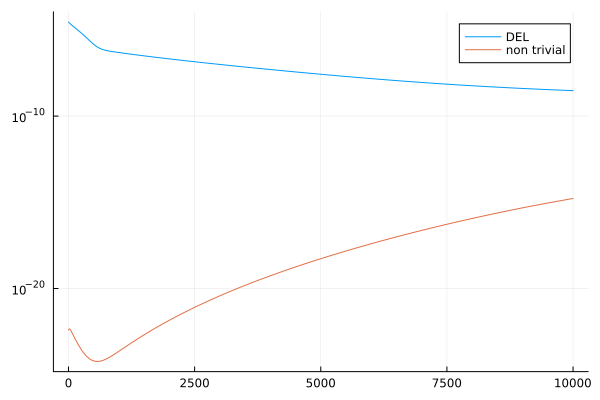

In [29]:

# behaviour TW optimisation scheme
plot(transpose(loss_hist_d_tw),yaxis =:log, labels=["DEL" "non trivial"])

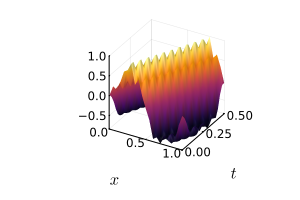

In [154]:
# compute TW profile from Fourier coefficients
c_tw_disc_opt = cfrhatR[1]
frhat_tw_disc = cfrhatR[2:end]
f_tw_disc_opt=frhatR_to_f(frhat_tw_disc);
     

# compute TW on discrete mesh using spectral interpolation
f_tw_disc_opt_fft = fft(f_tw_disc_opt)
u_tw_disc_opt(t,x) = SpectralInterpolation_dft(f_tw_disc_opt_fft,x-c_tw_disc_opt*t,l)
U_tw_disc_opt = real(u_tw_disc_opt.(TMesh,transpose(XMesh)))
plotU(U_tw_disc_opt)
#savefig("TW_locate_ROM_TW1.png")

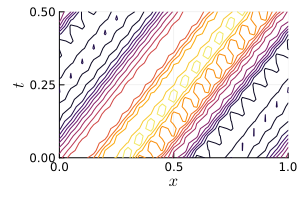

In [155]:
contourU(U_tw_disc_opt)

In [157]:
#savefig("TW_locate_ROM_TW1_contour.pdf")